# AUDIO CLASSIFICATION
The problem objective is clustering the male and female from a dataset of audio files from London using Unsupervised Learning.


# Machine Learning pipeline
**Input the audio files**, **pre processing** is done such as noise reduction, audio trimming for better feature extraction. The **features are extracted** and **data balancing** is done. The dataset is **splitted into training set and testing set**. The model is **trained** and **tested**.

# Transformation stage
In Transformation Stage, We first load the audio files by resampling the it into an array of floating points using ***load*** method from ***librosa*** library used for audio file manipulation. This data is then used to derive the various features such as:<br>
`1) Power<br>
2) Mean Pitch<br>
3) Standard Deviation of Pitch<br>
4) Mean of Voiced flags<br>
5) MFCC<br>

These features are better for the accurate prediction of the model.

# Modelling

It is an Unsupervised learning.
<br>
The most used and accurate unsupervised method is Kmeans clustering.
<br>
So KMeans clustering is used for the problem.

# Methodology

Since it is an unsupervised learning we are clustering the dataset for female and male based on the features extracted. And the features are used in KMeans method and visualisation is plotted.

# Dataset

Collected audio files is uploaded in google drive folder : '/content/drive/MyDrive/Data/MLEndLS/extracts/'.
There is a total of 2500 audio files provided.

MOUNTING DRIVE

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


AUDIO FILES

In [ ]:
sample_path = '/content/drive/MyDrive/Data/MLEndLS/extracts/*.wav'
files = glob.glob(sample_path)
len(files)

2500

SAMPLE AUDIO 

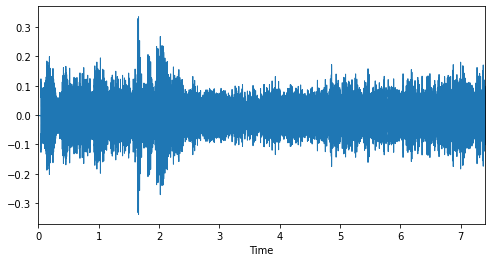

In [ ]:
for _ in range(0,1):
  n = np.random.randint(100)
  display(ipd.Audio(files[n]))
  plt.figure(figsize=(8,4))
  data,sample_rate=librosa.load(files[n])
  librosa.display.waveplot(data,sr=sample_rate)
  ipd.Audio(files[n])

IMPORTING DATASET

In [ ]:
MLENDLS_df = pd.read_csv('./MLEndLS.csv').set_index('file_id') 
MLENDLS_df

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176
...,...,...,...,...
2496.wav,westend,trafalgar,outdoor,S151
2497.wav,campus,square,outdoor,S6
2498.wav,westend,national,indoor,S96


NOISE REDUCTION

In [ ]:
import math
import scipy as sp
from scipy import signal
from IPython.display import Audio
import random

def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='lowpass')
    yf = signal.lfilter(b,a,y)
    return yf 

PITCH EXTRACTION

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

FEATURE EXTRACTION

In [ ]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    try:
      file_name = file.split('/')[-1]
      yi = labels_file.loc[fileID]['in_out']=='indoor'

      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs,offset=0.5,duration=3)
      if scale_audio: x = x/np.max(np.abs(x))
      x = f_high(x,fs)
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)

      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [power,pitch_mean,pitch_std,voiced_fr]
      X.append(xi)
      y.append(yi)
    except: 
      print(fileID)  
  return np.array(X),np.array(y)

In [ ]:
X,y = getXy(files, labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

 26%|██▌       | 650/2500 [06:02<17:07,  1.80it/s]<ipython-input-7-c97eb33d40a8>:11: RuntimeWarning: invalid value encountered in true_divide
  if scale_audio: x = x/np.max(np.abs(x))


2206.wav


 39%|███▉      | 977/2500 [09:06<13:57,  1.82it/s]

0033.wav


 40%|███▉      | 999/2500 [09:18<13:38,  1.83it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|████      | 1000/2500 [09:19<20:50,  1.20it/s]

0055.wav


100%|██████████| 2500/2500 [23:06<00:00,  1.80it/s]


SPLITTING DATASET

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)

KMEANS CLUSTERING MODEL

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2,random_state=0)
label = kmeans.fit_predict(X_train)
print(label)

[0 0 0 ... 1 1 0]


PLOTTING 

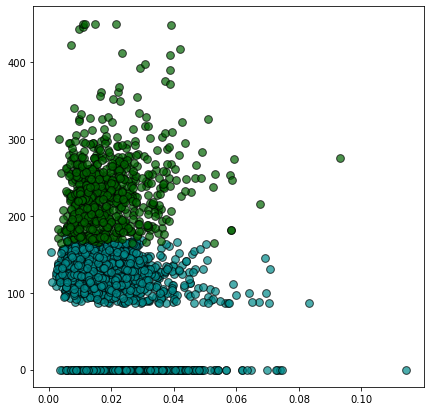

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
colors = ('#008B8B', 'darkgreen')

for value in [0, 1]:
  ax.scatter(X_train[label == value, 0], X_train[label == value, 1],
             s=60, c=colors[value],edgecolor='k',alpha=0.7)


Clustering Using Mfcc feature extraction

In [ ]:
def extract_mfcc(x,n_mfcc=25,fs = None):
        mfcc = librosa.feature.mfcc(x, fs, n_mfcc=n_mfcc)

        mfcc_mean = mfcc.mean(axis=1).T
        mfcc_std = mfcc.std(axis=1).T
        mfcc_feature = np.hstack([mfcc_mean, mfcc_std])
        return mfcc_feature

In [ ]:
def getX(files, scale_audio=False, onlySingleDigit=False):
  X = []
  for file in tqdm(files):
    try:
      fileID = file.split('/')[-1]
      file_name = file.split('/')[-1]

      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      feature = []
      feature = extract_mfcc(x,13,fs)
 
      X.append(feature)
    except:
      print(file.split('/')[-1])
  return np.array(X)

In [ ]:
X = getX(files, scale_audio=True, onlySingleDigit=True)

 26%|██▌       | 649/2500 [00:53<02:26, 12.67it/s]<ipython-input-13-43a1378cafe2>:10: RuntimeWarning: invalid value encountered in true_divide
  if scale_audio: x = x/np.max(np.abs(x))
 26%|██▌       | 653/2500 [00:54<02:22, 12.98it/s]

2206.wav


 39%|███▉      | 980/2500 [01:20<01:51, 13.61it/s]

0033.wav


 40%|███▉      | 998/2500 [01:22<02:33,  9.82it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|████      | 1002/2500 [01:22<02:03, 12.09it/s]

0055.wav


100%|██████████| 2500/2500 [03:25<00:00, 12.17it/s]


CLUSTERING MODEL

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2,random_state=0)
label = kmeans.fit_predict(X)
print(label)

[1 0 0 ... 0 0 0]


PLOTTING

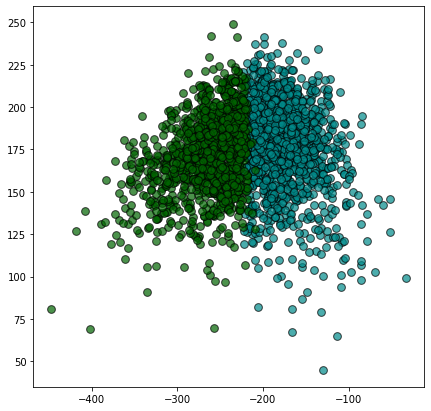

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
colors = ('#008B8B', 'darkgreen')

for l in [0, 1]:
  ax.scatter(X[label == l, 0], X[label == l, 1],
             s=60, c=colors[l],edgecolor='k',alpha=0.7)

# Conclusions

The clustering is done and from the visualisation we can say that the clusters formed is male and female with the green clusters represent the female because the pitch value is high and blue cluster is male with low pitch.

Also used mfcc for feature extraction and visualised the plotting.